In [1]:
# import libary
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm, trange

# used for ML
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae



In [2]:
# load data file in pandas
raw_data = pd.read_csv("Data_Marketing_Customer_Analysis_Round2.csv", index_col=0)
work_data = raw_data

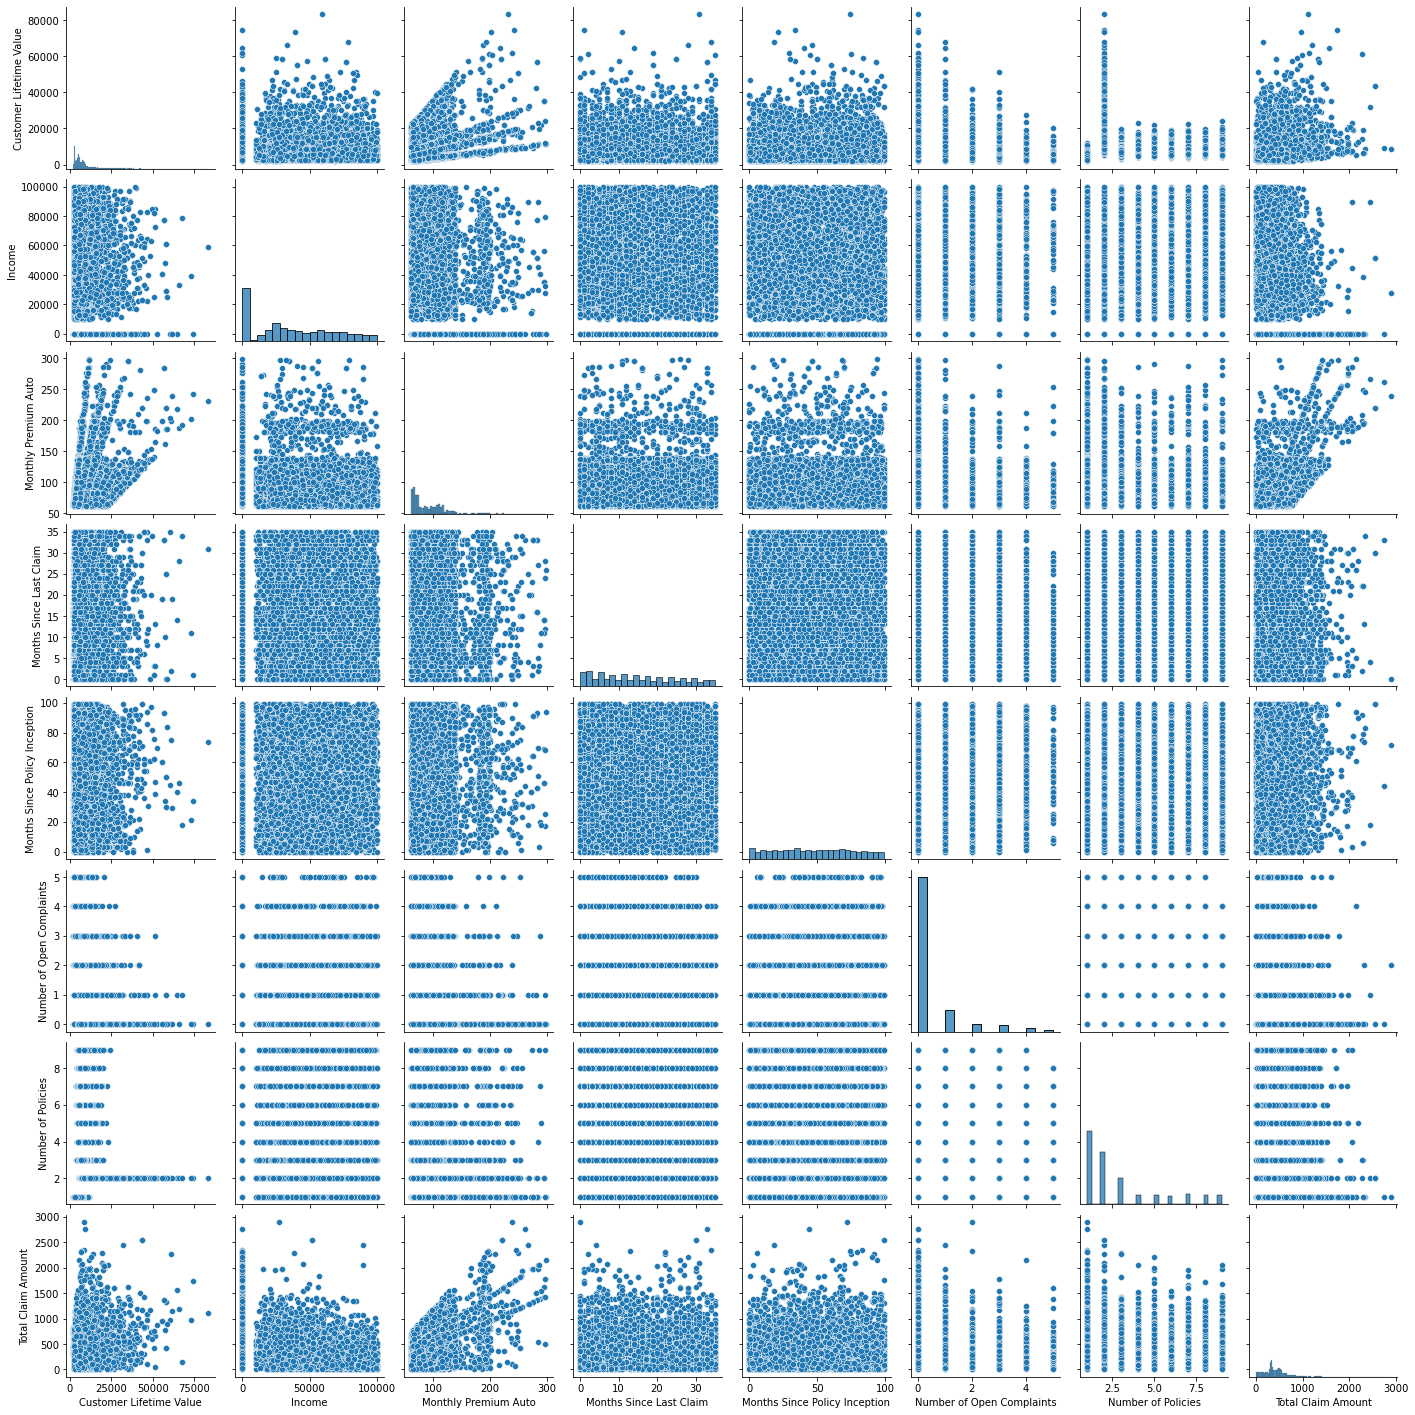

In [3]:
sns.pairplot(raw_data)

In [4]:
# counting nan values to decide which ones could remove
for i in work_data.columns:
    print(i, work_data[i].isnull().sum())

Customer 0
State 631
Customer Lifetime Value 0
Response 631
Coverage 0
Education 0
Effective To Date 0
EmploymentStatus 0
Gender 0
Income 0
Location Code 0
Marital Status 0
Monthly Premium Auto 0
Months Since Last Claim 633
Months Since Policy Inception 0
Number of Open Complaints 633
Number of Policies 0
Policy Type 0
Policy 0
Renew Offer Type 0
Sales Channel 0
Total Claim Amount 0
Vehicle Class 622
Vehicle Size 622
Vehicle Type 5482


In [5]:
# lower column names
work_data.columns = work_data.columns.str.lower()

#lower values
for i in work_data:
    if work_data[i].dtype == 'object':
        work_data[i] = work_data[i].str.lower()

work_data.head()

,customer,state,customer lifetime value,response,coverage,education,effective to date,employmentstatus,gender,income,...,number of open complaints,number of policies,policy type,policy,renew offer type,sales channel,total claim amount,vehicle class,vehicle size,vehicle type
0,dk49336,arizona,4809.216960,no,basic,college,2/18/11,employed,m,48029,...,0.0,9,corporate auto,corporate l3,offer3,agent,292.800000,four-door car,medsize,NaN
1,kx64629,california,2228.525238,no,basic,college,1/18/11,unemployed,f,0,...,0.0,1,personal auto,personal l3,offer4,call center,744.924331,four-door car,medsize,NaN
2,lz68649,washington,14947.917300,no,basic,bachelor,2/10/11,employed,m,22139,...,0.0,2,personal auto,personal l3,offer3,call center,480.000000,suv,medsize,a
3,xl78013,oregon,22332.439460,yes,extended,college,1/11/11,employed,m,49078,...,0.0,2,corporate auto,corporate l3,offer2,branch,484.013411,four-door car,medsize,a
4,qa50777,oregon,9025.067525,no,premium,bachelor,1/17/11,medical leave,f,23675,...,NaN,7,personal auto,personal l2,offer1,branch,707.925645,four-door car,medsize,NaN


In [6]:
# drop not neccesary columns

# 1. customer, effective to date
# 2. vehicle types as it holds more than 4500 nan values

work_data.drop(columns=['customer','vehicle type', 'renew offer type', 'policy type', 'policy', 'effective to date'], inplace=True)

In [7]:
work_data.head()

#drop rows in state where nan
work_data.dropna(subset=['state', 'vehicle size', 'months since last claim'], inplace=True)

In [8]:
work_data.head()

,state,customer lifetime value,response,coverage,education,employmentstatus,gender,income,location code,marital status,monthly premium auto,months since last claim,months since policy inception,number of open complaints,number of policies,sales channel,total claim amount,vehicle class,vehicle size
0,arizona,4809.216960,no,basic,college,employed,m,48029,suburban,married,61,7.0,52,0.0,9,agent,292.800000,four-door car,medsize
1,california,2228.525238,no,basic,college,unemployed,f,0,suburban,single,64,3.0,26,0.0,1,call center,744.924331,four-door car,medsize
2,washington,14947.917300,no,basic,bachelor,employed,m,22139,suburban,single,100,34.0,31,0.0,2,call center,480.000000,suv,medsize
3,oregon,22332.439460,yes,extended,college,employed,m,49078,suburban,single,97,10.0,3,0.0,2,branch,484.013411,four-door car,medsize
6,california,5035.035257,no,basic,doctor,employed,f,37405,urban,married,63,8.0,99,3.0,4,branch,287.556107,four-door car,medsize


In [9]:
# fill wierd values
# income = 0
#work_data.income.describe()
work_data['income'] = work_data['income'].replace(0, work_data['income'].mean())


### copy dataset for later modification and usage 

In [10]:
numerical_data = work_data._get_numeric_data()
loop_test_data = work_data.copy()
x = pd.DataFrame()

In [11]:
income = loop_test_data['income']
state = loop_test_data['state']

In [12]:
x = pd.concat([income, state],axis=1)

In [13]:
x 

,income,state
0,48029.000000,arizona
1,37657.380009,california
2,22139.000000,washington
3,49078.000000,oregon
6,37405.000000,california
...,...,...
10903,59855.000000,arizona
10904,37657.380009,nevada
10906,61146.000000,oregon
10907,39837.000000,arizona


In [14]:
# create list with categorical data
cat_norm = ['state','response', 'employmentstatus','gender', 'location code', 'sales channel', 'vehicle class', 'marital status']

In [15]:
# set ordonal values

print(work_data['education'].unique())
print(work_data['coverage'].unique())
print(work_data['vehicle size'].unique())
print(work_data['number of open complaints'].unique())

['college' 'bachelor' 'doctor' 'high school or below' 'master']
['basic' 'extended' 'premium']
['medsize' 'small' 'large']
[0. 3. 1. 2. 4. 5.]


In [16]:
work_data.columns

#raw_data

Index(['state', 'customer lifetime value', 'response', 'coverage', 'education',
       'employmentstatus', 'gender', 'income', 'location code',
       'marital status', 'monthly premium auto', 'months since last claim',
       'months since policy inception', 'number of open complaints',
       'number of policies', 'sales channel', 'total claim amount',
       'vehicle class', 'vehicle size'],
      dtype='object')

In [17]:
enc = OrdinalEncoder()
edu = [['high school or below', 0], ['college', 1], ['bachelor', 2], ['master', 3], ['doctor', 4]]
veh_size = [['small',0], ['medsize',1], ['larger',2]]
cov = [['basic',0], ['extended',1], ['premium',2]]

enc.fit(edu)
work_data['education'] = enc.fit_transform(work_data['education'].values.reshape(-1,1))

enc.fit(veh_size)
work_data['vehicle size'] = enc.fit_transform(work_data['vehicle size'].values.reshape(-1,1))

enc.fit(cov)
work_data['coverage'] = enc.fit_transform(work_data['coverage'].values.reshape(-1,1))


In [18]:
print(work_data['education'].unique())
print(work_data['coverage'].unique())
print(work_data['vehicle size'].unique())
print(work_data['number of open complaints'].unique())

[1. 0. 2. 3. 4.]
[0. 1. 2.]
[1. 2. 0.]
[0. 3. 1. 2. 4. 5.]


In [19]:
# set dummies values on all 
work_data = pd.get_dummies(work_data,cat_norm)


In [20]:
# check if datatypes fits
work_data.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('uint8')], dtype=object)

In [21]:
# split x/y

y = work_data['total claim amount']
x = work_data.drop(columns='total claim amount')

In [22]:
# scale x
scaler = StandardScaler()

x = pd.DataFrame(scaler.fit_transform(x))

In [23]:
# check x
x

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.465131,-0.732899,-0.400957,0.037710,-0.936442,-0.803856,0.141031,-0.422250,2.524561,-0.166682,...,1.275530,-0.625215,-0.489405,-0.411917,0.988245,-0.134795,-0.143383,-0.236545,-0.494726,-0.510108
1,-0.840745,-0.732899,-0.400957,-0.439749,-0.849248,-1.200968,-0.790719,-0.422250,-0.822648,-0.166682,...,-0.783988,-0.625215,2.043299,-0.411917,0.988245,-0.134795,-0.143383,-0.236545,-0.494726,-0.510108
2,1.010536,-0.732899,-1.124597,-1.154141,0.197079,1.876656,-0.611536,-0.422250,-0.404247,-0.166682,...,-0.783988,-0.625215,2.043299,-0.411917,-1.011895,-0.134795,-0.143383,-0.236545,2.021323,-0.510108
3,2.085337,0.791999,-0.400957,0.086001,0.109885,-0.506021,-1.614960,-0.422250,-0.404247,-0.166682,...,-0.783988,1.599450,-0.489405,-0.411917,0.988245,-0.134795,-0.143383,-0.236545,-0.494726,-0.510108
4,-0.432263,-0.732899,0.322683,-0.451368,-0.878312,-0.704577,1.825350,2.873245,0.432555,-0.166682,...,-0.783988,1.599450,-0.489405,-0.411917,0.988245,-0.134795,-0.143383,-0.236545,-0.494726,-0.510108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,-0.761692,-0.732899,-0.400957,0.582122,-0.558602,1.479543,1.216128,3.971744,-0.822648,-0.166682,...,-0.783988,1.599450,-0.489405,-0.411917,-1.011895,-0.134795,-0.143383,-0.236545,-0.494726,1.960371
9130,1.633560,-0.732899,1.046323,-0.439749,2.725701,-0.108908,-0.575700,-0.422250,-0.404247,-0.166682,...,-0.783988,1.599450,-0.489405,-0.411917,-1.011895,-0.134795,6.974332,-0.236545,-0.494726,-0.510108
9131,-0.399601,-0.732899,-0.400957,0.641554,-0.820183,-0.803856,0.714416,-0.422250,1.269358,-0.166682,...,-0.783988,1.599450,-0.489405,-0.411917,0.988245,-0.134795,-0.143383,-0.236545,-0.494726,-0.510108
9132,2.312518,0.791999,-1.124597,-0.339410,3.132606,-0.406743,0.535234,-0.422250,-0.404247,-0.166682,...,-0.783988,-0.625215,-0.489405,2.427671,-1.011895,-0.134795,6.974332,-0.236545,-0.494726,-0.510108


array([[<AxesSubplot:title={'center':'customer lifetime value'}>,
        <AxesSubplot:title={'center':'coverage'}>,
        <AxesSubplot:title={'center':'education'}>],
       [<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly premium auto'}>,
        <AxesSubplot:title={'center':'months since last claim'}>],
       [<AxesSubplot:title={'center':'months since policy inception'}>,
        <AxesSubplot:title={'center':'number of open complaints'}>,
        <AxesSubplot:title={'center':'number of policies'}>],
       [<AxesSubplot:title={'center':'total claim amount'}>,
        <AxesSubplot:title={'center':'vehicle size'}>, <AxesSubplot:>]],
      dtype=object)

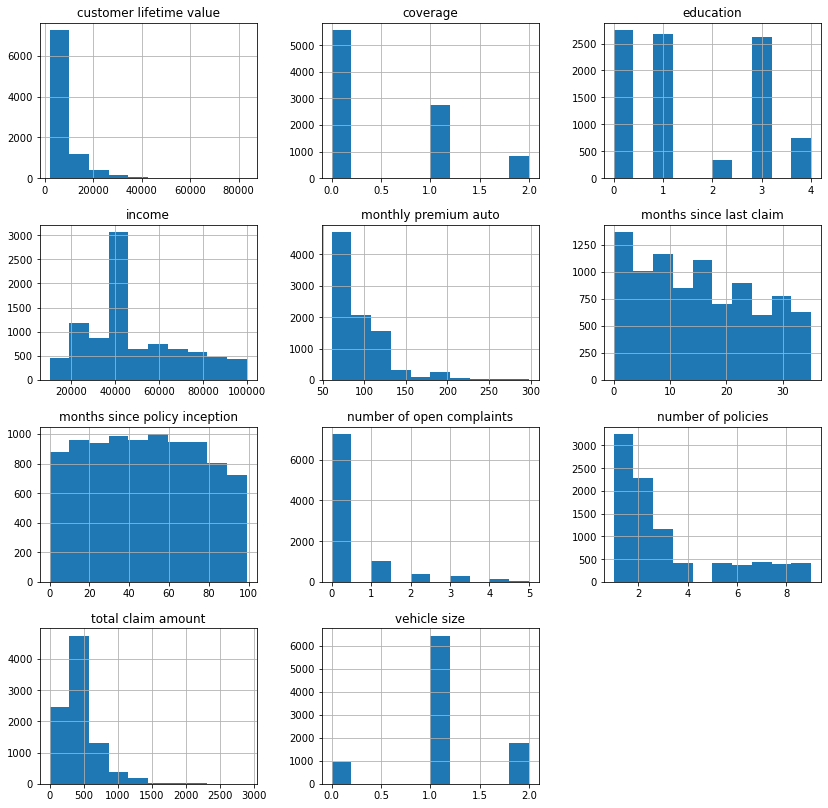

In [24]:
raw_data.hist(figsize=(14,14))

In [25]:
# split dataset -> train 80% to test 20%
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.20)

In [26]:
# create model and apply
linear_model = LinearRegression()

linear_model.fit(x_train, y_train)

LinearRegression()

x_train = sm.add_constant(x_train) # adding a constant
model = sm.OLS(list(y_train), x_train).fit()
predictions = model.predict(x_train) 

print_model = model.summary()
print_model

In [27]:
# getting the R-score
print(linear_model.score(x,y))

0.7660752592220226


In [28]:
y_pred = linear_model.predict(x_test)

In [29]:
print('mae:', mae(y_true = y_test, y_pred = y_pred))
print('mse:', mse(y_true = y_test,y_pred = y_pred))
print('r2:',r2_score(y_true = y_test, y_pred = y_pred))

mae: 95.74333320583555
mse: 18679.843544299423
r2: 0.7699085850612234


In [30]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

Text(0.5, 1.0, 'Test Set Residual histogram')

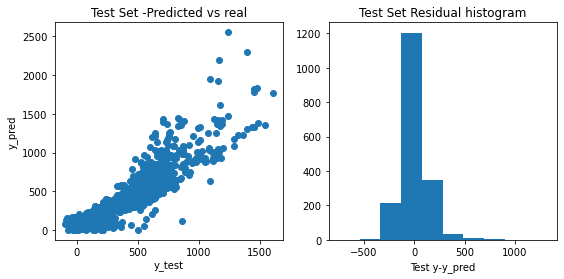

In [31]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

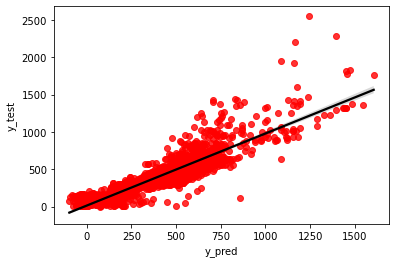

In [32]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

## How to make it complicated

#### creating a base function for running a single set ***(data + scalertype + model)***

> input: 
>
>       x_data: cleaned x_data, with preferd series/columns
>
>       y_data: result series
>
>       scaler: scalermodel -> instance e.g s=StandartScaler()
>
>       model: type of model -> instance e.g m=LinearRegression()
>
>  output:
>
>       - used columns as list
>
>       - Dictonary holding MSE, MAE and R2 value from this solution

In [33]:
def linear_solver(x_data, y_data, scaler, model):
    
    # store used column names for later processing
    used_columns = x_data.columns 

    # scale given dataset
    x = pd.DataFrame(scaler.fit_transform(x_data))
    y = y_data


    # fit to model
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.20)
    model.fit(x_train, y_train)
    
    # create predictions
    y_pred = model.predict(x_test)

    # get results 
    results = {}
    results['mse'] = mse(y_true = y_test,y_pred = y_pred)
    results['mae'] = mae(y_true = y_test, y_pred = y_pred)
    results['R2'] = r2_score(y_true = y_test, y_pred = y_pred)


    return used_columns, results

#### How to use

> create lists of data, seperated in numerical, ordonal categories and normal categegies 
>
> iterate over the range of data_types, where the income is fixed and just add different series of data
>
> create predictions 
>
> compare the results with respect to its different iterations

### prepare lists of data types for iteration

#### numerical

In [34]:
# handle numerical series

list_numerical_data = list(numerical_data)
list_numerical_data.pop(list_numerical_data.index('total claim amount')) # as this is going to be the y-axis
list_numerical_data.pop(list_numerical_data.index('income')) # as this is the minimum required data...no income -> normaly no car ^^
len(list_numerical_data)

6

#### list categories in unorderd type...not rankable

In [35]:
list_cat_normal = [ \
        'state',
        'response',
        'employmentstatus',
        'gender',
        'location code',
        'sales channel',
        'vehicle class',
        'marital status']
len(list_cat_normal)

8

#### dic of categories which can be ranked

> remind, still room for imrpvement e.g simplfy by grouping

In [36]:
dic_cat_ordonal = {\
    'education':[['high school or below', 0], ['college', 1], ['bachelor', 2], ['master', 3], ['doctor', 4]],
    'vehicle size': [['small',0], ['medsize',1], ['larger',2]],
    'coverage': [['basic',0], ['extended',1], ['premium',2]]
    }
len(dic_cat_ordonal)

3

#### create function to pass ordinal categories to work data

In [37]:
enc = OrdinalEncoder()

def create_cat_ordinal_data(data_set, k, v):
    #print('create ordinal ', k,v)
    enc.fit(v)
    data_set[k] = enc.fit_transform(data_set[k].values.reshape(-1,1))
    return data_set

### create test case loop

In [38]:

# create an emtpy data frame
x_data = pd.DataFrame()


def loop_cat_ord(count, data):

    for k,v in dic_cat_ordonal.items():
        if count == 0:
            break
        data = pd.concat([data, loop_test_data[k]], axis=1)    
        data = create_cat_ordinal_data(data, k, v)

        count -= 1
    #print(data)
    return data


def loop_cat_norma(count, data):
    for l_cat in list_cat_normal:
        if count == 0:
            break

        data = pd.concat([data, loop_test_data[l_cat]], axis=1)
        data = pd.get_dummies(data,l_cat)
        count -= 1
        
    #print('loop cat', data)
    return data


def loop_numeric(count, data):
    for numeric in list_numerical_data:
        if count == 0: 
            break
        
        data = pd.concat([data, loop_test_data[numeric]], axis=1)
        count -= 1
        
    #print('loop numeric', data.count())
    return data


In [39]:

scaler = StandardScaler()
model = LinearRegression()

x_data = pd.DataFrame()

def test_run(num: int, cat_n: int, cat_ord: int):
    
    x_data = pd.DataFrame()    
    x_data = pd.concat([x_data, loop_test_data['income']], axis=1) # income is mandatory and 

    
    x_data = loop_numeric(num, x_data)
    
    x_data = loop_cat_norma(cat_n, x_data)
    
    x_data = loop_cat_ord(cat_ord, x_data)

    y = loop_test_data['total claim amount']

    head, res = linear_solver(x_data, y, scaler, model)
    
    return head, res

#### series count

> numerical: 6
>
> cat unorderd: 8
>
> cat orderd: 3
>
> (6 + 1) \* (8 + 1) \* (3 + 1) = 252 possibilties

In [40]:
n = 6 + 1
c = 8 + 1
a = 3 + 1 

combined = [(n1,c2,a3) for n1 in range(n) for c2 in range(c) for a3 in range(a)]

In [41]:
print('start', combined[0:5])
print('end',combined[-5:])
print('length', len(combined))

start [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0)]
end [(6, 7, 3), (6, 8, 0), (6, 8, 1), (6, 8, 2), (6, 8, 3)]
length 252


#### run tescases 

In [42]:

k = []
v = []
for n,ca,co in tqdm(combined):
    name, res = test_run(n, ca, co)
    k.append(name)
    v.append(res)


  0%|          | 0/252 [00:00<?, ?it/s]

In [43]:
#store results in dataframe
values = pd.DataFrame(v)
index_v = pd.DataFrame(k)


### Show top 20 with lowest combination

In [44]:
complete = pd.concat([index_v, values], axis=1)
complete = complete.sort_values(by='mse')
complete.head(20)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,mse,mae,R2
104,income,customer lifetime value,monthly premium auto,state_arizona,state_california,state_nevada,state_oregon,state_washington,response_no,response_yes,...,None,None,None,None,None,None,None,16048.476491,90.182591,0.775338
237,income,customer lifetime value,monthly premium auto,months since last claim,months since policy inception,number of open complaints,number of policies,state_arizona,state_california,state_nevada,...,None,None,None,None,None,None,None,16903.717535,93.402282,0.784396
205,income,customer lifetime value,monthly premium auto,months since last claim,months since policy inception,number of open complaints,state_arizona,state_california,state_nevada,state_oregon,...,None,None,None,None,None,None,None,16996.488450,94.881863,0.770593
210,income,customer lifetime value,monthly premium auto,months since last claim,months since policy inception,number of open complaints,state_arizona,state_california,state_nevada,state_oregon,...,education,vehicle size,None,None,None,None,None,17367.033998,93.899463,0.772709
215,income,customer lifetime value,monthly premium auto,months since last claim,months since policy inception,number of open complaints,state_arizona,state_california,state_nevada,state_oregon,...,marital status_divorced,marital status_married,marital status_single,education,vehicle size,coverage,None,17469.337925,92.845502,0.786792
209,income,customer lifetime value,monthly premium auto,months since last claim,months since policy inception,number of open complaints,state_arizona,state_california,state_nevada,state_oregon,...,education,None,None,None,None,None,None,17852.805735,96.415736,0.764055
248,income,customer lifetime value,monthly premium auto,months since last claim,months since policy inception,number of open complaints,number of policies,state_arizona,state_california,state_nevada,...,vehicle class_two-door car,marital status_divorced,marital status_married,marital status_single,None,None,None,17914.955502,92.754728,0.782685
142,income,customer lifetime value,monthly premium auto,months since last claim,state_arizona,state_california,state_nevada,state_oregon,state_washington,response_no,...,marital status_single,education,vehicle size,None,None,None,None,17930.507312,95.647606,0.787202
134,income,customer lifetime value,monthly premium auto,months since last claim,state_arizona,state_california,state_nevada,state_oregon,state_washington,response_no,...,None,None,None,None,None,None,None,17939.801831,95.707908,0.763661
141,income,customer lifetime value,monthly premium auto,months since last claim,state_arizona,state_california,state_nevada,state_oregon,state_washington,response_no,...,marital status_single,education,None,None,None,None,None,18191.687644,96.647189,0.769084


/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mse', ylabel='Density'>

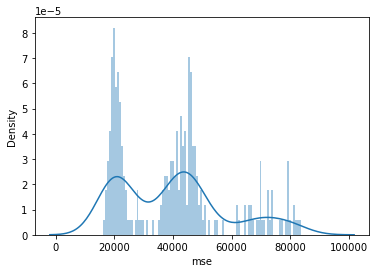

In [45]:
sns.distplot(complete.mse, bins= 100)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='R2', ylabel='Density'>

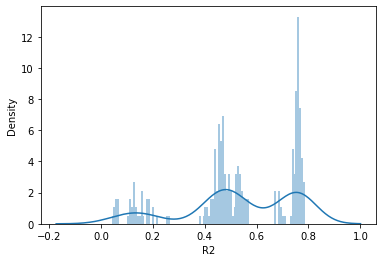

In [46]:

sns.distplot(complete['R2'], bins=100)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mae', ylabel='Density'>

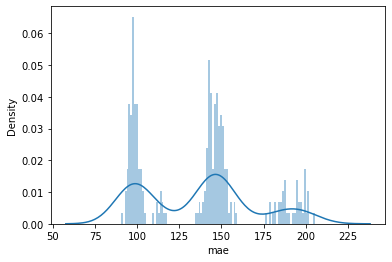

In [47]:
sns.distplot(complete['mae'], bins=100)